In [1]:
# Annie Polish
# Summer 2019

# README: How to prepare data for this script
# Open DatCon (from datfile.net)
# Set Parsing Options to "Engineered, then DatDefined"
# Set the Sample Rate to 100Hz
# Set the output location to ./CSV_files (relative to this script)
# GO!
# In this file, set BASENAME to the name of your file
# Run this script. The plot will be saved to ./plots

import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import math
from datetime import datetime
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance

plt.rcParams.update({'font.size': 16})

In [85]:
########################
# CONSTANT DEFINITIONS #
########################
BASENAME = "FLY130" # filename to run on
BORDER = 0.00007 # sets the border around the dataset, in degrees of lat/long
PLOT_BG = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')
COL_LIST = ["rtkdata:Lat_P", "rtkdata:Lon_P", "rtkdata:Hmsl_P", "GPS:dateTimeStamp", "offsetTime", "GPS(0):Time",
           "GPS(0):Long", "GPS(0):Lat", "GPS(1):Long", "GPS(1):Lat", "GPS(2):Long", "GPS(2):Lat"]
print(COL_LIST) 

['rtkdata:Lat_P', 'rtkdata:Lon_P', 'rtkdata:Hmsl_P', 'GPS:dateTimeStamp', 'offsetTime', 'GPS(0):Time', 'GPS(0):Long', 'GPS(0):Lat', 'GPS(1):Long', 'GPS(1):Lat', 'GPS(2):Long', 'GPS(2):Lat']


Change "BASENAME" to set which file you run on

All CSVs should be in ./CSV_files

Plots land in ./plots

In [86]:
# accepts a DataFrame with "Lat", "Lon", "hmsl"
# fills in the isMoving column with bools
# isMoving is a guess at whether the drone is currently moving
def fill_moving(df: pd.DataFrame, xy_thresh= 0.00000003, h_thresh=0.005, win = 50):
    latSer = pd.Series(df["Lat"].values, index=df.index)
    lonSer = pd.Series(df["Lon"].values, index=df.index)
    hmslSer= pd.Series(df["hmsl"].values,index=df.index)
    df = df.assign(std_lat = latSer.rolling(50, center=True).std())
    df = df.assign(std_lon = lonSer.rolling(50, center=True).std())
    df = df.assign(std_hmsl = hmslSer.rolling(50, center=True).std())
    df = df.assign(isMoving = np.logical_or(np.greater(df["std_lat"].values, xy_thresh), 
        np.greater(df["std_lon"].values, xy_thresh),
        np.greater(df["std_hmsl"].values, h_thresh)))
    return df

In [87]:
def fill_avMov(df: pd.DataFrame, win = 20):
    latSer = pd.Series(df["Lat"].values, index=df.index)
    lonSer = pd.Series(df["Lon"].values, index=df.index)
    hmslSer= pd.Series(df["hmsl"].values,index=df.index)
    df = df.assign(avMovLat = latSer.rolling(win, center=True).mean())
    df = df.assign(avMovLon = lonSer.rolling(win, center=True).mean())
    df = df.assign(avMovHmsl = hmslSer.rolling(win, center=True).mean())
    return df

In [88]:
# returns the statistics of the coordinates in a given time interval
def stationaryStats(df, startTime, endTime, avg=False):
    print('hello stationary stats')
    # slice off part of the dataframe
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    if (avg):
        lat_arr = df_slice["avMovLat"].values
        lon_arr = df_slice["avMovLon"].values
        hmsl_arr= df_slice["avMovHmsl"].values
    else:
        lat_arr  = df_slice["Lat"].values
        lon_arr  = df_slice["Lon"].values
        hmsl_arr = df_slice["hmsl"].values
    # find max and min of each coordinate, and the distance that represents
    max_lat  = np.max(lat_arr)
    min_lat  = np.min(lat_arr)
    max_lon  = np.max(lon_arr)
    min_lon  = np.min(lon_arr)
    lat_dist = geopy.distance.distance((min_lat, lon_arr[0]), (max_lat, lon_arr[0])).m
    lon_dist = geopy.distance.distance((lat_arr[0], min_lon), (lat_arr[0], max_lon)).m
    print("Latitude spread: "+str(lat_dist))
    print("Longitude spread: "+str(lon_dist))
    print("Diagonal distance: "+str(math.sqrt(lat_dist**2 + lon_dist**2)))
    print("Double check: "+str(geopy.distance.distance((min_lat, min_lon),(max_lat, max_lon)).m))
    # find the standard deviation of each coordinate
    lat_dev  = np.std(lat_arr)
    lon_dev  = np.std(lon_arr)
    hmsl_dev = np.std(hmsl_arr)
    # convert stddev in degrees to stddev in meters
    startCoords = (lat_arr[0], lon_arr[0])
    latCoords = (lat_arr[0]+lat_dev, lon_arr[0])
    lonCoords = (lat_arr[0], lon_arr[0]+lon_dev)
    endCoords = (lat_arr[0]+lat_dev, lon_arr[0]+lon_dev)
    lat_dist = geopy.distance.distance(startCoords, latCoords).m
    lon_dist = geopy.distance.distance(startCoords, lonCoords).m
    xy_dist = geopy.distance.distance(startCoords, endCoords).m
    # print and return
    print("Latitude standard deviation: "+str(lat_dist)+" meters")
    print("Longitude standard deviation: "+str(lon_dist)+" meters")
    print("Height standard deviation: "+str(hmsl_dev)+" meters")
    print("Diagonal lat-lon stddev: "+str(xy_dist)+" meters")
    return (lat_dist, lon_dist, hmsl_dev, xy_dist)

In [89]:
def distBetweenTimes(df, startTime, endTime):
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    start_lat = df_slice.iloc[0]["Lat"]
    start_lon = df_slice.iloc[0]["Lon"]
    end_lat = df_slice.iloc[-1]["Lat"]
    end_lon = df_slice.iloc[-1]["Lon"]
    dist = geopy.distance.distance((start_lat, start_lon), (end_lat, end_lon)).m
    print(start_lat)
    print(start_lon)
    print(end_lat)
    print(end_lon)
    print("distance: "+str(dist))

In [90]:
# adds the column time_int
# expects to find "sec_elapsed" and "sec_abs"
def interpolateTime(df):
    first_time = df["sec_abs"].values[0]
    tick_row = 0
    # find the first clock tick
    while df["sec_abs"].values[tick_row] == first_time:
        tick_row += 1
    #print(tick_row)
    # row number tick_row is the first row with this second stamp.
    elapsed_time = df.iloc[tick_row]["sec_elapsed"]
    abs_time     = df.iloc[tick_row]["sec_abs"]
    offset = abs_time - elapsed_time
    df = df.assign(new_time = np.add(df["sec_elapsed"].values, offset))
        
    years, months, days = [], [], []
    for row in df["timestamp"].values:
        years.append(row[:4])
        months.append(row[5:7])
        days.append(row[8:10])
    df = df.assign(years = years)
    df = df.assign(months = months)
    df = df.assign(days = days)
    
    timestamp = df["new_time"].values
    hours, minutes, seconds, millis = [], [], [], []
    mill = 0
    stamp_string = timestamp.astype('U')
    for row in stamp_string:
        #print(row)
        hours.append(row[:2])
        minutes.append(row[2:4])
        seconds.append(row[4:6])
        mill = row[7:] or "0"
        mill = int(mill)
        if mill < 100: mill *= 10
        while(mill > 1000): mill = mill/10
        millis.append(int(mill))
    df = df.assign(hours = hours)
    df = df.assign(minutes = minutes)
    df = df.assign(seconds = seconds)
    df = df.assign(ms = millis)
    
    df_timing = df[["years", "months", "days", "hours", "minutes", "seconds", "ms"]]
    
    df_stamp = pd.to_datetime(df_timing)
        
    df = df.assign(timestamp = df_stamp.values)
    df = df.drop(["years", "months", "days", "hours", "minutes", "seconds", "ms", "new_time"], axis=1)

    return(df)

In [91]:
FLY = pd.read_csv("./CSV_files/"+BASENAME+".csv", sep=",", header=0, usecols=COL_LIST)#, nrows=15000)

In [92]:
# rename columns, do some initial processing
rtk_p = pd.DataFrame(columns=["Lat", "Lon", "hmsl"])
rtk_p["Lat"] = FLY["rtkdata:Lat_P"]
rtk_p["Lon"] = FLY["rtkdata:Lon_P"]
rtk_p["hmsl"] = FLY["rtkdata:Hmsl_P"]
rtk_p["sec_elapsed"] = FLY["offsetTime"]
rtk_p["sec_abs"] = FLY["GPS(0):Time"]
rtk_p["lat0"] = FLY["GPS(0):Lat"]
rtk_p["lon0"] = FLY["GPS(0):Long"]
rtk_p["lat1"] = FLY["GPS(1):Lat"]
rtk_p["lon1"] = FLY["GPS(1):Long"]
rtk_p["lat2"] = FLY["GPS(2):Lat"]
rtk_p["lon2"] = FLY["GPS(2):Long"]
rtk_p["timestamp"] = FLY["GPS:dateTimeStamp"]
rtk_p = rtk_p.iloc[20:]
rtk_p = rtk_p.iloc[:-20]
rtk_p = rtk_p.where(rtk_p != 0.)
#print(rtk_p)
rtk_p.dropna(inplace=True)
#rtk_p = rtk_p.dropna(thresh=2)
#print(rtk_p)

In [93]:
rtk_p = interpolateTime(rtk_p)

In [94]:
rtk_p = fill_moving(rtk_p)
#print(rtk_p)

/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [95]:
rtk_p= fill_avMov(rtk_p)
print(rtk_p)
rtk_p.dropna(inplace=True)
print(rtk_p)

              Lat        Lon       hmsl  sec_elapsed  sec_abs       lat0  \
921     41.320646 -72.922355  26.732840     -353.019   194318  41.320448   
922     41.320646 -72.922355  26.732840     -353.009   194318  41.320448   
923     41.320646 -72.922355  26.732840     -352.999   194318  41.320448   
924     41.320646 -72.922355  26.732840     -352.989   194318  41.320448   
925     41.320646 -72.922355  26.732840     -352.977   194318  41.320448   
926     41.320646 -72.922355  26.732840     -352.966   194318  41.320448   
927     41.320646 -72.922355  26.732840     -352.955   194318  41.320448   
928     41.320646 -72.922355  26.732840     -352.945   194318  41.320448   
929     41.320646 -72.922355  26.732840     -352.934   194318  41.320448   
930     41.320461 -72.922314  44.157784     -352.924   194318  41.320448   
931     41.320461 -72.922314  44.157784     -352.914   194318  41.320448   
932     41.320461 -72.922314  44.157784     -352.904   194318  41.320448   
933     41.3

In [96]:
# retrieve the date
print(FLY["GPS:dateTimeStamp"].values[100])
date = FLY["GPS:dateTimeStamp"].values[100]
stamp = date
date = date[:10]

2019-06-24T19:43:09Z


beginning plot render
[-72.92249538694384, -72.9221265708536, 41.32039868495231, 41.32088219111447]
saved plot
2019-06-24T19:51:21.283000000
2019-06-24T19:59:21.277000000


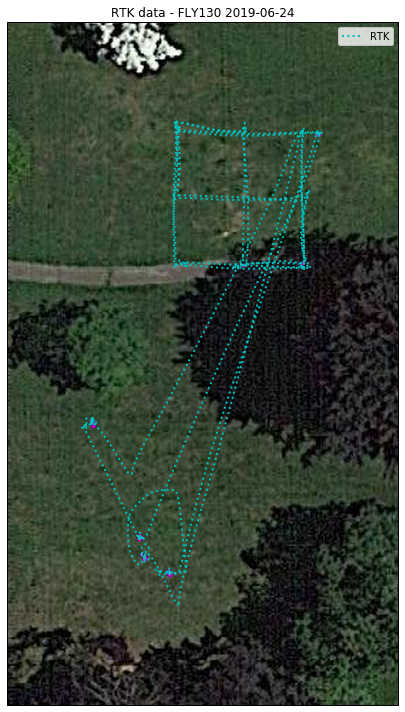

In [111]:
# PLOT A TIME SLICE

startTime = 450
endTime=1250

df_slice = rtk_p[rtk_p["sec_elapsed"] > startTime]
df_slice = df_slice[df_slice["sec_elapsed"] < endTime]

# begin the plot
print("beginning plot render")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
print([min(df_slice["Lon"].values)-BORDER, max(df_slice["Lon"].values)+BORDER, 
    min(df_slice["Lat"].values)-BORDER, max(df_slice["Lat"].values)+BORDER])
ax.set_extent([min(df_slice["Lon"].values)-BORDER, max(df_slice["Lon"].values)+BORDER, 
    min(df_slice["Lat"].values)-BORDER, max(df_slice["Lat"].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
ax.add_image(PLOT_BG, 20, interpolation='spline36')
# plot all the data from the onboard gps
# plot the RTK gps data
rtk_mov = df_slice[df_slice["isMoving"] == True]
rtk_stop = df_slice[df_slice["isMoving"] == False]
#plt.plot(df_slice["lon0"].values, df_slice["lat0"].values, 'k', transform=ccrs.Geodetic(), label="Onboard GPS")
#plt.plot(df_slice["lon1"].values, df_slice["lat1"].values, 'k', transform=ccrs.Geodetic())
#plt.plot(df_slice["lon2"].values, df_slice["lat2"].values, 'k', transform=ccrs.Geodetic())
#plt.plot(rtk_p["Lon"].values, rtk_p["Lat"].values, 'c-', transform=ccrs.Geodetic())
plt.plot(df_slice["avMovLon"].values, df_slice["avMovLat"].values, 'c:', linewidth=2, transform=ccrs.Geodetic(), label="RTK")
#plt.scatter(rtk_mov["Lon"].values, rtk_mov["Lat"].values, c='c', transform=ccrs.Geodetic())
plt.scatter(rtk_stop["Lon"].values,rtk_stop["Lat"].values,c='m', s=5, transform=ccrs.Geodetic())
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("RTK data - "+BASENAME+" "+str(date))
plt.grid()
fig.canvas.draw()
plt.tight_layout()
plt.savefig("./plots/Cut_"+BASENAME+".png")
print("saved plot")
print(df_slice["timestamp"].values[0])
print(df_slice["timestamp"].values[-1])
plt.show()

beginning plot render
[-72.92264850294123, -72.92204511117424, 41.32015067269476, 41.32096720124439]
saved plot


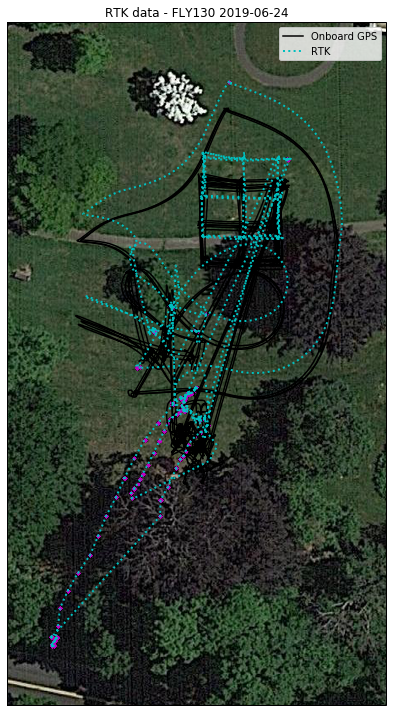

In [101]:
# begin the plot
print("beginning plot render")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
print([min(rtk_p["Lon"].values)-BORDER, max(rtk_p["Lon"].values)+BORDER, 
    min(rtk_p["Lat"].values)-BORDER, max(rtk_p["Lat"].values)+BORDER])
ax.set_extent([min(rtk_p["Lon"].values)-BORDER, max(rtk_p["Lon"].values)+BORDER, 
    min(rtk_p["Lat"].values)-BORDER, max(rtk_p["Lat"].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
ax.add_image(PLOT_BG, 20, interpolation='spline36')
# plot all the data from the onboard gps
# plot the RTK gps data
rtk_mov = rtk_p[rtk_p["isMoving"] == True]
rtk_stop = rtk_p[rtk_p["isMoving"] == False]
plt.plot(rtk_p["lon0"].values, rtk_p["lat0"].values, 'k', transform=ccrs.Geodetic(), label="Onboard GPS")
plt.plot(rtk_p["lon1"].values, rtk_p["lat1"].values, 'k', transform=ccrs.Geodetic())
plt.plot(rtk_p["lon2"].values, rtk_p["lat2"].values, 'k', transform=ccrs.Geodetic())
#plt.plot(rtk_p["Lon"].values, rtk_p["Lat"].values, 'c-', transform=ccrs.Geodetic())
plt.plot(rtk_p["avMovLon"].values, rtk_p["avMovLat"].values, 'c:', linewidth=2, transform=ccrs.Geodetic(), label="RTK")
#plt.scatter(rtk_mov["Lon"].values, rtk_mov["Lat"].values, c='c', transform=ccrs.Geodetic())
plt.scatter(rtk_stop["Lon"].values,rtk_stop["Lat"].values,c='m', s=5, transform=ccrs.Geodetic())
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("RTK data - "+BASENAME+" "+str(date))
plt.grid()
fig.canvas.draw()
plt.tight_layout()
plt.savefig("./plots/"+BASENAME+".png")
print("saved plot")
plt.show()

In [98]:
fig = plt.figure(figsize=(9,9))
plt.title("Longitude vs Seconds Elapsed")
plt.ylim(min(rtk_p["Lon"].values), max(rtk_p["Lon"].values))
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["Lon"].values)
plt.grid()
ax = plt.gca()
ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)
plt.xlim(0,max(rtk_p["sec_elapsed"].values))
plt.tight_layout()
plt.savefig("./plots/"+BASENAME+"_lon.png")
plt.show()

In [29]:
fig = plt.figure(figsize=(9,9))
plt.title("Latitude vs Seconds Elapsed")
plt.ylim(min(rtk_p["Lat"].values), max(rtk_p["Lat"].values))
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["Lat"].values)
plt.grid()
ax = plt.gca()
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)
plt.xlim(0,max(rtk_p["sec_elapsed"].values))
plt.savefig("./plots/"+BASENAME+"_lat.png")
plt.show()

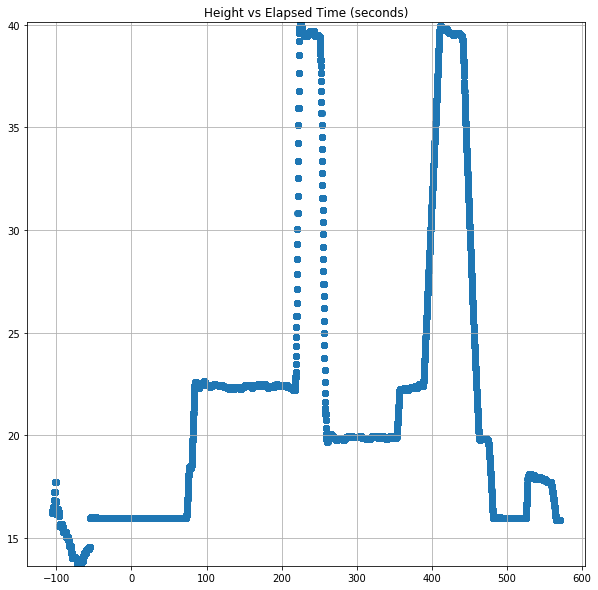

In [30]:
fig = plt.figure(figsize=(10,10))
plt.title("Height vs Elapsed Time (seconds)")
plt.ylim(min(rtk_p["hmsl"].values), max(rtk_p["hmsl"].values))
plt.scatter(rtk_p["sec_elapsed"].values, rtk_p["hmsl"].values)
plt.grid()
plt.savefig("./plots/"+BASENAME+"_hmsl.png")
plt.show()

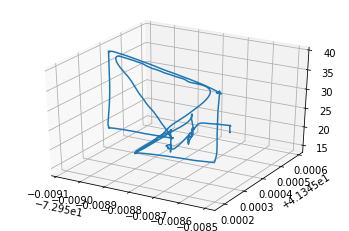

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(rtk_p['Lon'].values, rtk_p['Lat'].values, rtk_p['hmsl'].values)
plt.savefig("./plots/3d"+BASENAME+".png")
plt.show()

In [32]:
if(BASENAME == "FLY088"):
    stationaryStats(rtk_p,50,140)
    stationaryStats(rtk_p,200,280)
    stationaryStats(rtk_p,340,430)
    stationaryStats(rtk_p,490,600)
    stationaryStats(rtk_p,650,750)
    stationaryStats(rtk_p,800,900)
    stationaryStats(rtk_p,950,1050)
    stationaryStats(rtk_p,1090,1180)

if(BASENAME == "FLY097"):
    stationaryStats(rtk_p,250,330)
    stationaryStats(rtk_p,400,470)
    stationaryStats(rtk_p,500,600)
    stationaryStats(rtk_p,650,720)
    stationaryStats(rtk_p,780,860)
    stationaryStats(rtk_p,900,980)
    stationaryStats(rtk_p,1030,1100)
    stationaryStats(rtk_p,1150,1300)
    
if(BASENAME == "FLY120"):
    stationaryStats(rtk_p,145,175)
    stationaryStats(rtk_p,150,170)
    stationaryStats(rtk_p,185,215)
    stationaryStats(rtk_p,225,255)
    stationaryStats(rtk_p,275,540)
    
if(BASENAME == "FLY117"):
    stationaryStats(rtk_p,100,200, avg=True)
    stationaryStats(rtk_p,220,250, avg=True)
    stationaryStats(rtk_p,270,290, avg=True)
    stationaryStats(rtk_p,310,325, avg=True)
    
if(BASENAME == "FLY126"):
    stationaryStats(rtk_p,100,200)
    stationaryStats(rtk_p,275,350)
    
#FLY88:
#(50,140), (200,280), (340,430), (490,600), (650,750), (800,900), (950,1050), (1090,1180)

hello stationary stats
Latitude spread: 1.218474196445482
Longitude spread: 0.6337341066169209
Diagonal distance: 1.3734257480086098
Double check: 1.3734257717991827
Latitude standard deviation: 0.20867321278980613 meters
Longitude standard deviation: 0.11292066693105211 meters
Height standard deviation: 0.0575295153631511 meters
Diagonal lat-lon stddev: 0.23726690905893114 meters
hello stationary stats
Latitude spread: 0.8587891185353109
Longitude spread: 0.7514045795673181
Diagonal distance: 1.1411080546159484
Double check: 1.1411080542817198
Latitude standard deviation: 0.17536864838985844 meters
Longitude standard deviation: 0.16798683023602196 meters
Height standard deviation: 0.04568008346418072 meters
Diagonal lat-lon stddev: 0.2428450886932127 meters


In [20]:
## FLY88, FLY97 ##
#distBetweenTimes(rtk_p, 270, 410)

## FLY117 ##
distBetweenTimes(rtk_p, 150, 240)
distBetweenTimes(rtk_p, 240, 280)
distBetweenTimes(rtk_p, 280, 315)
distBetweenTimes(rtk_p, 315, 350)
## FLY120 ##
#distBetweenTimes(rtk_p, 100, 160)
#distBetweenTimes(rtk_p, 160, 200)
#distBetweenTimes(rtk_p, 200, 240)
#distBetweenTimes(rtk_p, 240, 300)

41.319029900600576
-72.9212488413374
41.31898639630534
-72.92126190418541
distance: 4.953837875853642
41.31898639630534
-72.92126190418541
41.31899918155638
-72.92131836243857
distance: 4.935803276331581
41.31899918155638
-72.92131836243857
41.31904427674829
-72.92130665709655
distance: 5.103269175372914
41.31904427674829
-72.92130665709655
41.31903200935875
-72.92124962497289
distance: 4.965750614128027
